https://machinebox.io/docs/tagbox/recognizing-images

In [2]:
import requests
import operator
import os
import io
import base64
import pathlib
from PIL import Image
import json
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import sys
print(sys.version)

HEADERS = {'content-type': 'application/json'} ; # charset=utf-8
ENDPOINT = "http://localhost:8080/tagbox/check"
#ENDPOINT = "http://192.168.0.30:8080/tagbox/check"

def download_image(url):
    """"Convenience to download web image."""
    file_name = url.split("/")[-1]
    with open(file_name, "wb") as file:
        response = requests.get(url)
        file.write(response.content)
        print(file_name + " downloaded from " + url)
    return file_name

def print_json(json_data):
    PrettyPrinter().pprint(json_data)

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
ls

Classification box introduction.ipynb  cat.2.jpg
Classificationbox images.ipynb         model_sentiment1.classificationbox
Facebox.ipynb                          monkey.jpg
Facebox_HA_development.ipynb           people.jpg
Tagbox tag images.ipynb                thebeatles.jpg
cat.1.jpg


In [3]:
# url = "https://machinebox.io/samples/images/monkey.jpg"

In [13]:
# file_name = download_image(url)
#file_name = 'people.jpg'
file_name = 'person.jpg'

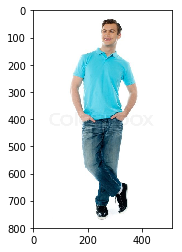

In [14]:
img = plt.imread(file_name)  # Creates an ndarray
plt.imshow(img)
plt.show()

## Post the file

In [15]:
%%time
files = {
    'file': (file_name, open(file_name, 'rb')),
}

response = requests.post(ENDPOINT, files=files)

CPU times: user 5.11 ms, sys: 7.3 ms, total: 12.4 ms
Wall time: 1.37 s


In [16]:
print_json(response.json())

{'custom_tags': [],
 'success': True,
 'tags': [{'confidence': 0.8266854882240295, 'tag': 'Clothing'},
          {'confidence': 0.559300422668457, 'tag': 'Sleeve'},
          {'confidence': 0.5139391422271729, 'tag': 'Arm'},
          {'confidence': 0.5068365931510925, 'tag': 'T-shirt'},
          {'confidence': 0.33109891414642334, 'tag': 'Blue'},
          {'confidence': 0.3238378167152405, 'tag': 'Outerwear'}]}


## Post bytes

In [8]:
img_file_data = pathlib.Path('monkey.jpg').read_bytes()

In [9]:
base64_img = base64.b64encode(img_file_data).decode('ascii')

In [31]:
#%%time # times out on Synology
HEADER = {'content-type': 'application/json, charset=utf-8'}
response = requests.post(ENDPOINT, headers=HEADER, json={"base64": base64_img}).json()

In [32]:
print_json(response)

{'custom_tags': [],
 'success': True,
 'tags': [{'confidence': 0.9197548031806946, 'tag': 'Wildlife'},
          {'confidence': 0.8748621940612793, 'tag': 'Animal'},
          {'confidence': 0.8732861876487732,
           'tag': 'Pre-dreadnought battleship'},
          {'confidence': 0.8389277458190918, 'tag': 'Primate'},
          {'confidence': 0.8311088681221008, 'tag': 'Mammal'},
          {'confidence': 0.736111581325531, 'tag': 'Jungle'},
          {'confidence': 0.6977391839027405, 'tag': 'Monkey'},
          {'confidence': 0.5723546147346497, 'tag': 'Rainforest'},
          {'confidence': 0.4915062487125397, 'tag': 'Ape'},
          {'confidence': 0.46555307507514954, 'tag': 'Zoo'}]}


In [24]:
response['success']

True

In [25]:
data = response['tags']
data

[{'confidence': 0.9197548031806946, 'tag': 'Wildlife'},
 {'confidence': 0.8748621940612793, 'tag': 'Animal'},
 {'confidence': 0.8732861876487732, 'tag': 'Pre-dreadnought battleship'},
 {'confidence': 0.8389277458190918, 'tag': 'Primate'},
 {'confidence': 0.8311088681221008, 'tag': 'Mammal'},
 {'confidence': 0.736111581325531, 'tag': 'Jungle'},
 {'confidence': 0.6977391839027405, 'tag': 'Monkey'},
 {'confidence': 0.5723546147346497, 'tag': 'Rainforest'},
 {'confidence': 0.4915062487125397, 'tag': 'Ape'},
 {'confidence': 0.46555307507514954, 'tag': 'Zoo'}]

In [26]:
classifications  = {'Pet': 92.2, 'Dog': 84.4, 'Mammal': 59.4, 'Animal': 58.4}

In [27]:
next(iter(classifications))

'Pet'

In [28]:
classifications = {item['tag']: round(100.0*item['confidence'], 1) for item in tags}
classifications = sorted(classifications.items(), key=operator.itemgetter(1))
classifications.reverse()
classifications

NameError: name 'tags' is not defined

In [ ]:
classifications[0][0]

## Working via URL

In [ ]:
%%time
response = requests.post(ENDPOINT, headers=HEADERS, json={"url": url}).json()